# Text classification by RNN for BBC sport dataset


In [1]:
# install tensorflow text processor
!pip install -q -U tensorflow-text

     |████████████████████████████████| 3.4MB 9.8MB/s 


In [2]:
import collections
import pathlib
import re
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import shutil
import os

## Load data from url and create train, test and validation set

In [3]:
data_url = 'http://mlg.ucd.ie/files/datasets/bbcsport-fulltext.zip'
dataset = utils.get_file(
    'bbcsport-fulltext.zip',
    data_url,
    cache_subdir='datasets', hash_algorithm='auto',
    extract=True, archive_format='auto', cache_dir=None)
dataset_dir = pathlib.Path(dataset).parent

876544/869685 [==============================] - 0s 0us/step


In [4]:
list(dataset_dir.iterdir())

[PosixPath('/root/.keras/datasets/bbcsport'),
 PosixPath('/root/.keras/datasets/bbcsport-fulltext.zip')]

In [5]:
sport_dir = dataset_dir/'bbcsport'

remove_dir = os.path.join(sport_dir, 'README.TXT')
os.remove(remove_dir)
# shutil.rmtree(remove_dir)
list(sport_dir.iterdir())

[PosixPath('/root/.keras/datasets/bbcsport/tennis'),
 PosixPath('/root/.keras/datasets/bbcsport/athletics'),
 PosixPath('/root/.keras/datasets/bbcsport/cricket'),
 PosixPath('/root/.keras/datasets/bbcsport/rugby'),
 PosixPath('/root/.keras/datasets/bbcsport/football')]

In [6]:
# check sample folder
rugby = sport_dir/'rugby'
len(list(rugby.iterdir()))

147

### Create train, validation and test dataset

In [7]:
# check one sample
sample_file = sport_dir/'rugby'/'035.txt'
with open(sample_file) as file:
  print(file.read())

Williams says he will never quit

Defiant Matt Williams says he will not quit as Scotland coach even if his side slump to a new low with defeat by Italy at Murrayfield.

That would leave the Scots as favourites to win the Wooden Spoon for the second year running. "I have never quit anything in my life, apart from maybe painting the kitchen," he told BBC Sport. "The support we have been given from Murrayfield in my whole time here has been 100%." Williams has yet to experience an RBS Six Nations victory after seven attempts and Scotland have lost 12 of their 14 games under his leadership. But he rejected the comparison made in some media sources with Berti Vogts, recently sacked as Scotland football manager after a poor run of results.

"How can a German football coach and an Australian rugby coach have anything in common?" he asked. "It is a bizarre analogy. It is so absurd that it borders on the humorous." Williams insists that he is revelling in the pressure, despite the possibility 

In [8]:
# read file 
batch_size = 32
seed = 15

raw_train_ds = preprocessing.text_dataset_from_directory(
    sport_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_test_ds = preprocessing.text_dataset_from_directory(
    sport_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 737 files belonging to 5 classes.
Using 590 files for training.
Found 737 files belonging to 5 classes.
Using 147 files for validation.


In [9]:
# get class name and map it to a dictionary
raw_train_ds.class_names
# make a label dictionary
label_dict = dict(zip(range(len(raw_train_ds.class_names)), raw_train_ds.class_names))
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to athletics
Label 1 corresponds to cricket
Label 2 corresponds to football
Label 3 corresponds to rugby
Label 4 corresponds to tennis


In [10]:
label_dict

{0: 'athletics', 1: 'cricket', 2: 'football', 3: 'rugby', 4: 'tennis'}

In [11]:
# take a sample and to see what's inside
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'Mourinho to escape FA charge\n\nChelsea boss Jose Mourinho will not face any Football Association action over the comments he made after their Carling Cup tie with Manchester United.\n\nMourinho intimated that United boss Sir Alex Ferguson influenced referee Neale Barry after the duo walked down the tunnel together at half-time. But an FA spokesman told BBC Sport: "We are not taking action over Mourinho. "We have looked at the comments and we have decided that no further action is required. That is the end of it." Mourinho was concerned that Ferguson\'s conversation with Barry was followed by an inconsistent display by the official. "I see one referee in the first half and another in the second," said Mourinho. "If the FA ask me what happened, I will tell them. What I saw and felt made it easier to understand a few things.\n\n"Maybe when I turn 60 and have been managing in the same league for 20 years and have the respect of everybody I will have the power to speak to peop

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  """Function to cache and prefetch data for better performance"""
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

int_train_ds = configure_dataset(raw_train_ds)
int_val_ds = configure_dataset(raw_train_ds.shuffle(590).take(59// batch_size))
int_test_ds = configure_dataset(raw_test_ds)

## Prepare the embedding layer

In [15]:
# Pick the most frequency 10000 words to make the vocabulary
VOCAB_SIZE = 10000

def customized(input_data):
  """remove all special characters, not just default punctuations"""
  lowercase = tf.strings.lower(input_data)
  stripped = tf.strings.regex_replace(lowercase, r'[^a-z]', ' ')
  return stripped

#
encoder_layer = TextVectorization(
    standardize = customized,
    max_tokens=VOCAB_SIZE,
    output_mode='int', output_sequence_length=VOCAB_SIZE)

encoder_layer.adapt(int_train_ds.map(lambda text, labels: text))

In [17]:
# check the first 20 words
len(encoder_layer.get_vocabulary())
encoder_layer.get_vocabulary()[:20]

['',
 '[UNK]',
 'the',
 'to',
 'a',
 'and',
 'in',
 'of',
 's',
 'i',
 'for',
 'he',
 'on',
 'is',
 'was',
 'it',
 'but',
 'with',
 'that',
 'have']

In [19]:
# check the text of one sample
text_batch, label_batch = next(iter(int_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'Rivals back anti-racism campaign\n\nManchester United and Arsenal players will wear black and white wristbands when they face each other on Tuesday as part of a new anti-racism initiative.\n\nLaunching the \'Stand Up, Speak Up\' scheme with Thierry Henry, United\'s Rio Ferdinand said football\'s ruling bodies should do more to tackle racist abuse. "If an offence is committed, they should make a stand against it before the players do," Ferdinand said. "It should be up to the authorities to come forward." Ferdinand added: "It is a massive issue that needs to be jumped on and addressed. "It is a bit sad that it has taken the initiative of a player to push this issue forward." Henry became involved with the campaign following comments directed at him last year by Luis Aragones.\n\nFerdinand claimed he was surprised by the lack of action taken against the Spain coach, saying: "I think if it had been the England manager who had said something like that, he wouldn\'t be i

In [21]:
# check the encoded text sample
first_question1 = tf.expand_dims(first_question, -1)
print("'int' vectorized question:",
      encoder_layer(first_question1))

'int' vectorized question: tf.Tensor([[ 855   64 1348 ...    0    0    0]], shape=(1, 10000), dtype=int64)


In [24]:
# check if they match
print("855 ---> ", encoder_layer.get_vocabulary()[855])
print("64 ---> ", encoder_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(encoder_layer.get_vocabulary())))

855 --->  rivals
64 --->  look
Vocabulary size: 10000


# Build a RNN model, using the encoder_layer to be the first layer, it converts text to encoded vectors

In [25]:
def create_model(vocab_size, num_labels):
  """Make a CNN model"""
  model = tf.keras.Sequential([
      encoder_layer,                        
      layers.Embedding(input_dim=vocab_size,
        output_dim=8, mask_zero=True),
      layers.Bidirectional(layers.LSTM(9)),
      layers.Dense(5, activation='relu', 
      activity_regularizer=tf.keras.regularizers.L2(0.01)), 
      # extra regularation as noises to prevent overfitting
      layers.Dense(num_labels, activation='softmax')
  ])
  return model


In [30]:
# vocab_size is VOCAB_SIZE + 1 since 0 is used additionally for padding.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, 
                                              patience=5, mode='min', 
                                              restore_best_weights=True)
 
int_model = create_model(vocab_size=VOCAB_SIZE, num_labels=5)
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])


history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=100, 
                        callbacks=early_stopping)

Epoch 1/100
19/19 [==============================] - 18s 419ms/step - loss: 1.6077 - accuracy: 0.2779 - val_loss: 1.5961 - val_accuracy: 0.3438
Epoch 2/100
19/19 [==============================] - 5s 280ms/step - loss: 1.5908 - accuracy: 0.3291 - val_loss: 1.5711 - val_accuracy: 0.3438
Epoch 3/100
19/19 [==============================] - 5s 277ms/step - loss: 1.5601 - accuracy: 0.3291 - val_loss: 1.5079 - val_accuracy: 0.3438
Epoch 4/100
19/19 [==============================] - 5s 277ms/step - loss: 1.4674 - accuracy: 0.3296 - val_loss: 1.2599 - val_accuracy: 0.3438
Epoch 5/100
19/19 [==============================] - 5s 278ms/step - loss: 1.2662 - accuracy: 0.4221 - val_loss: 1.0440 - val_accuracy: 0.5000
Epoch 6/100
19/19 [==============================] - 5s 278ms/step - loss: 1.0508 - accuracy: 0.6056 - val_loss: 0.9608 - val_accuracy: 0.7188
Epoch 7/100
19/19 [==============================] - 5s 277ms/step - loss: 0.9533 - accuracy: 0.6936 - val_loss: 0.9437 - val_accuracy: 0.750

In [31]:
# check if all layers support masking
print([layer.supports_masking for layer in int_model.layers])

[False, True, True, True, True]


In [32]:
print("model on int vectorized data:")
print(int_model.summary())

model on int vectorized data:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 10000)             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10000, 8)          80000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 18)                1296      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 95        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 30        
Total params: 81,421
Trainable params: 81,421
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# test one sample
#tf.expand_dims(first_question)
print("Question", first_question1)
print("Label", first_label)
test = int_model.predict(first_question1)
print('The test label is', np.argmax(test))

Question tf.Tensor([b'Rivals back anti-racism campaign\n\nManchester United and Arsenal players will wear black and white wristbands when they face each other on Tuesday as part of a new anti-racism initiative.\n\nLaunching the \'Stand Up, Speak Up\' scheme with Thierry Henry, United\'s Rio Ferdinand said football\'s ruling bodies should do more to tackle racist abuse. "If an offence is committed, they should make a stand against it before the players do," Ferdinand said. "It should be up to the authorities to come forward." Ferdinand added: "It is a massive issue that needs to be jumped on and addressed. "It is a bit sad that it has taken the initiative of a player to push this issue forward." Henry became involved with the campaign following comments directed at him last year by Luis Aragones.\n\nFerdinand claimed he was surprised by the lack of action taken against the Spain coach, saying: "I think if it had been the England manager who had said something like that, he wouldn\'t be 

# Evaluate and plot the model

In [37]:
test_loss, test_acc = int_model.evaluate(int_val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1/1 [==============================] - 0s 138ms/step - loss: 0.2571 - accuracy: 1.0000
Test Loss: 0.2570543885231018
Test Accuracy: 1.0


In [43]:
# print out labels and predicted labels to see the accuracy
test_label = int_val_ds.map(lambda a, b: b)
tlabels = list(test_label.as_numpy_iterator())
print('True labels')
print(list(tlabels))
print()
pre_test = int_model.predict(int_val_ds.map(lambda a, b: a))
print('Predicted labels:')
test_prediction = np.argmax(pre_test, axis=1)
print(test_prediction)
print('Sample prediction', test_prediction)
print('Sample accuracy =', np.mean(tlabels == test_prediction))

True labels
[array([1, 4, 3, 4, 2, 3, 3, 3, 2, 0, 2, 0, 1, 0, 3, 4, 3, 2, 4, 2, 2, 1,
       2, 4, 1, 2, 2, 2, 0, 3, 1, 2], dtype=int32)]

Predicted labels:
[1 4 3 4 2 3 3 3 2 0 2 0 1 0 3 4 3 2 4 2 2 1 2 4 1 2 2 2 0 3 1 2]
Sample prediction [1 4 3 4 2 3 3 3 2 0 2 0 1 0 3 4 3 2 4 2 2 1 2 4 1 2 2 2 0 3 1 2]
Sample accuracy = 1.0


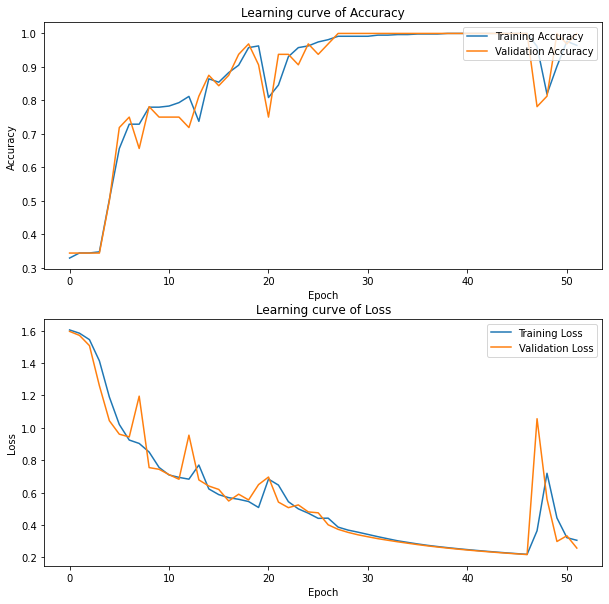

In [45]:
def learning_plot(record):
  """Function to plot the metrics"""
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  train_acc = record.history['accuracy']
  val_acc = record.history['val_accuracy']
  train_loss = record.history['loss']
  val_loss = record.history['val_loss']
  epoch = range(len(train_acc))
  ax1.plot(epoch, train_acc, label='Training Accuracy')
  ax2.plot(epoch, train_loss, label='Training Loss')
  ax1.plot(epoch, val_acc, label='Validation Accuracy')
  ax2.plot(epoch, val_loss, label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc = 'upper right')
  ax2.legend(loc = 'upper right')
  ax1.set_title('Learning curve of Accuracy')
  ax2.set_title('Learning curve of Loss')

  
learning_plot(history)